In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter
from scipy.optimize import root

In [8]:
fontsize_legend = 20
fontsize_axes = 24
fontsize_ticks = 16
linewidth_all = 3
markersize_all = 8

figsize_whole = (6,5)
folder_out = 'figures_paper'

def smooth_pv_data(pressure, window_len = 100):
    # window_len = 100
    poly_order = 2
    len_pressure, num_exp = np.shape(pressure)

    pressure_smooth = np.zeros((len_pressure, num_exp))

    for i in range(num_exp):
        pressure_smooth[:,i] = savgol_filter(pressure[:,i], window_len, poly_order)
    
    return pressure_smooth


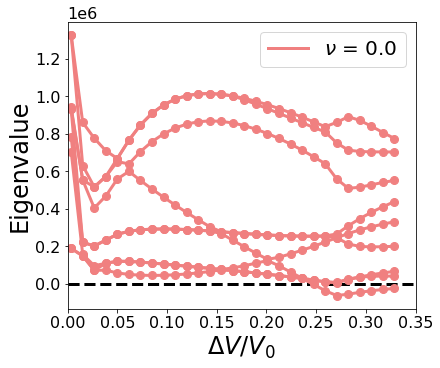

In [9]:
nu_try = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

initial_idx = 240

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd']

ax.hlines(0,0,0.35, 'k', '--', linewidth = linewidth_all)

for i,nu in enumerate(nu_try):
    if i==0:
        idx_cur = initial_idx + i
        data_path = f'data_out/4fold-test_nu-{idx_cur}_eig_val.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        # color_plot = plt.get_cmap(cmap_all[i])(0.7)
        color_plot = 'lightcoral'

        for j in range(np.shape(freq_all)[1]-1):
            ax.plot(-3*temp_all, freq_all[:,j], 'o', color = color_plot, markersize = markersize_all)
            if j == 0:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, label = rf'$\nu$ = {nu}', linewidth = linewidth_all)
            else:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, linewidth = linewidth_all)



ax.legend(loc = 'best', fontsize = fontsize_legend)
ax.set_xlabel('$\Delta V/V_0$', fontsize = fontsize_axes)
ax.set_ylabel('Eigenvalue', fontsize = fontsize_axes)
ax.tick_params(labelsize = fontsize_ticks)
ax.yaxis.offsetText.set_fontsize(fontsize_ticks)
ax.set_xlim(0,0.35)


# fig.savefig('data_processed/change_nu_4folds_val.jpg')
fig.savefig(f'{folder_out}/4folds_eigval_00_nolam0.jpg')


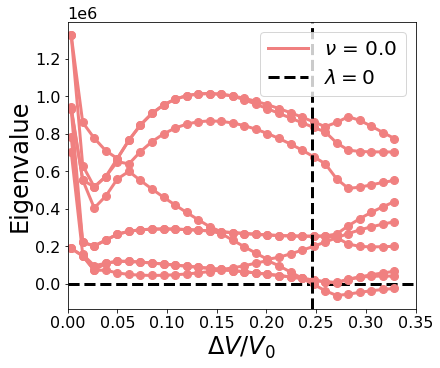

In [10]:
nu_try = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

initial_idx = 240

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd']

ax.hlines(0,0,0.35, 'k', '--', linewidth = linewidth_all)

for i,nu in enumerate(nu_try):
    if i==0:
        idx_cur = initial_idx + i
        data_path = f'data_out/4fold-test_nu-{idx_cur}_eig_val.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        # color_plot = plt.get_cmap(cmap_all[i])(0.7)
        color_plot = 'lightcoral'

        for j in range(np.shape(freq_all)[1]-1):
            ax.plot(-3*temp_all, freq_all[:,j], 'o', color = color_plot, markersize = markersize_all)
            if j == 0:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, label = rf'$\nu$ = {nu}', linewidth = linewidth_all)
            else:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, linewidth = linewidth_all)

ylim_cur = ax.get_ylim()
f = lambda x: np.interp(x,-3*temp_all,freq_all[:,0])
sol_root = root(f,0.25)
ax.vlines(float(sol_root.x),ylim_cur[0], ylim_cur[1], 'black', '--', linewidth = linewidth_all, label = '$\lambda = 0$')

ax.legend(loc = 'best', fontsize = fontsize_legend)
ax.set_xlabel('$\Delta V/V_0$', fontsize = fontsize_axes)
ax.set_ylabel('Eigenvalue', fontsize = fontsize_axes)
ax.tick_params(labelsize = fontsize_ticks)
ax.yaxis.offsetText.set_fontsize(fontsize_ticks)
ax.ticklabel_format(scilimits = (-5,3))
ax.set_xlim(0,0.35)
ax.set_ylim(ylim_cur)


# fig.savefig('data_processed/change_nu_4folds_val.jpg')
fig.savefig(f'{folder_out}/4folds_eigval_00.jpg', dpi = 300)


0.6769293551673012

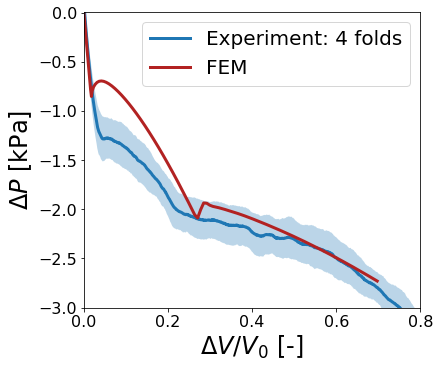

In [11]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

'''load exp data'''
data_all = np.loadtxt('exp_results/PV_4f_Fig1_exp.csv', skiprows = 2, delimiter = ',')
vol_all = data_all[:,0]

pressure_4_mean = np.mean(data_all[:,1:], axis = 1)
pressure_4_exp_std = np.std(data_all[:,1:], axis = 1)

pressure_4_smooth = smooth_pv_data(data_all[:,1:], 120)
pressure_4_smooth_mean = np.mean(pressure_4_smooth, axis = 1)
pressure_4_smooth_std = np.std(pressure_4_smooth, axis = 1)


#note: checked and this is averaged correctly w/o any extra volume stuff

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
pressure_0 = pressure_4_mean[0]

#plot exp
# ax.plot(vol_all/vol_0, pressure_4_mean, label = 'Experiment: 4 folds')
# ax.fill_between(vol_all/vol_0, pressure_4_mean + pressure_4_exp_std, pressure_4_mean - pressure_4_exp_std, alpha = 0.3)

ax.plot(vol_all/vol_0, pressure_4_smooth_mean, label = 'Experiment: 4 folds', linewidth = linewidth_all)
ax.fill_between(vol_all/vol_0, pressure_4_smooth_mean + pressure_4_smooth_std, pressure_4_smooth_mean - pressure_4_smooth_std, alpha = 0.3)

'''load sim data'''
t, E = (0.56, 1.4)
#plot nu = 0.5 up to \delta V/V_0 = 0.7 for fitted parameters
nu = 0.5
data_cur = np.loadtxt(f'data_out/4fold-fitting-400_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax.plot(vol_norm,pressure_kpa, label = 'FEM', color = 'firebrick', linewidth = linewidth_all)



#set parameters for plot
ax.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax.set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
ax.set_xlim(left = 0, right = 0.8)
ax.set_ylim(top = 0.01, bottom = -3)
ax.tick_params(labelsize = fontsize_ticks)
ax.yaxis.offsetText.set_fontsize(fontsize_ticks)


ax.legend(loc = 'best', fontsize = fontsize_legend)

fig.savefig(f'{folder_out}/4folds_pv.jpg', dpi = 300)
vol_norm[127]

array([-0.        ,  0.1662322 ,  0.36521835,  0.67692936])

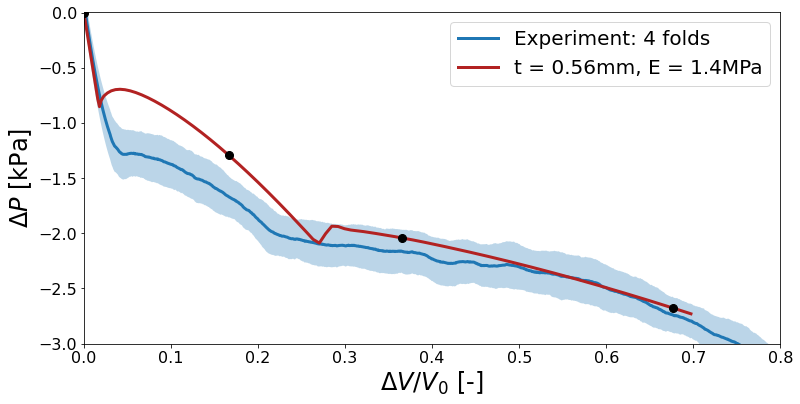

In [50]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

'''load exp data'''
data_all = np.loadtxt('exp_results/PV_4f_Fig1_exp.csv', skiprows = 2, delimiter = ',')
vol_all = data_all[:,0]

pressure_4_mean = np.mean(data_all[:,1:], axis = 1)
pressure_4_exp_std = np.std(data_all[:,1:], axis = 1)

pressure_4_smooth = smooth_pv_data(data_all[:,1:], 120)
pressure_4_smooth_mean = np.mean(pressure_4_smooth, axis = 1)
pressure_4_smooth_std = np.std(pressure_4_smooth, axis = 1)


#note: checked and this is averaged correctly w/o any extra volume stuff

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
pressure_0 = pressure_4_mean[0]

#plot exp
# ax.plot(vol_all/vol_0, pressure_4_mean, label = 'Experiment: 4 folds')
# ax.fill_between(vol_all/vol_0, pressure_4_mean + pressure_4_exp_std, pressure_4_mean - pressure_4_exp_std, alpha = 0.3)

ax.plot(vol_all/vol_0, pressure_4_smooth_mean, label = 'Experiment: 4 folds', linewidth = linewidth_all)
ax.fill_between(vol_all/vol_0, pressure_4_smooth_mean + pressure_4_smooth_std, pressure_4_smooth_mean - pressure_4_smooth_std, alpha = 0.3)

'''load sim data'''
frames_highlight = [0,37,60,127]
t, E = (0.56, 1.4)
#plot nu = 0.5 up to \delta V/V_0 = 0.7 for fitted parameters
nu = 0.5
data_cur = np.loadtxt(f'data_out/4fold-fitting-400_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax.plot(vol_norm,pressure_kpa, label = rf't = {t}mm, E = {E}MPa', color = 'firebrick', linewidth = linewidth_all)

for i, frame in enumerate(frames_highlight):
    ax.plot(vol_norm[frame],pressure_kpa[frame], 'o', color = 'k', markersize = markersize_all)



#set parameters for plot
ax.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax.set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
ax.set_xlim(left = 0, right = 0.8)
ax.set_ylim(top = 0.01, bottom = -3)
ax.tick_params(labelsize = fontsize_ticks)
ax.yaxis.offsetText.set_fontsize(fontsize_ticks)


ax.legend(loc = 'best', fontsize = fontsize_legend)

# fig.savefig('data_processed/4folds_pv.jpg', dpi = 300)
vol_norm[frames_highlight]

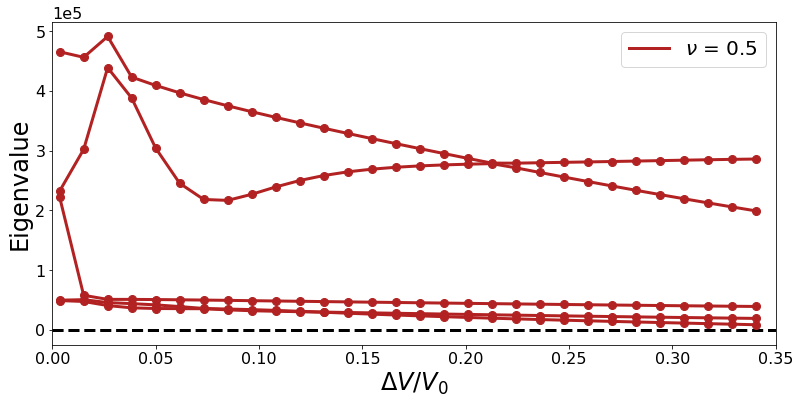

In [104]:
nu_try = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

initial_idx = 300

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd']

ax.hlines(0,0,0.35, 'k', '--', linewidth = linewidth_all)

for i,nu in enumerate(nu_try):
    if i > 4:
        idx_cur = initial_idx + i
        data_path = f'data_out/2fold-test_nu-{idx_cur}_eig_val.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        # color_plot = plt.get_cmap(cmap_all[i])(0.7)
        color_plot = 'firebrick'

        for j in range(np.shape(freq_all)[1] - 5):
            ax.plot(-3*temp_all, freq_all[:,j], 'o', color = color_plot, markersize = markersize_all)
            if j == 0:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, label = rf'$\nu$ = {nu}', linewidth = linewidth_all)
            else:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, linewidth = linewidth_all)



ax.legend(loc = 'best', fontsize = fontsize_legend)
ax.set_xlabel('$\Delta V/V_0$', fontsize = fontsize_axes)
ax.set_ylabel('Eigenvalue', fontsize = fontsize_axes)
ax.tick_params(labelsize = fontsize_ticks)
ax.yaxis.offsetText.set_fontsize(fontsize_ticks)
ax.ticklabel_format(scilimits = (-5,3))
ax.set_xlim(0,0.35)


fig.savefig(f'{folder_out}/2folds_eigval_05.jpg', dpi = 300)


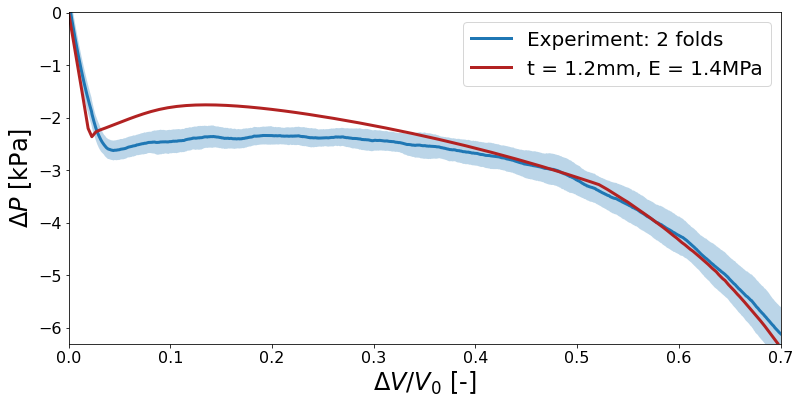

In [112]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

'''exp data'''
data_all = np.loadtxt('exp_results/PV_2f_Fig1_exp.csv', skiprows = 2, delimiter = ',')
vol_all = data_all[:,0]
pressure_2 = data_all[:,1:]
pressure_2_smooth = smooth_pv_data(pressure_2)
pressure_2_smooth_mean = np.mean(pressure_2_smooth, axis = 1)
pressure_2_smooth_std = np.std(pressure_2_smooth, axis = 1)

R = 8.8 #mm
H = 44.75 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

ax.plot(vol_all/vol_0, pressure_2_smooth_mean, label = 'Experiment: 2 folds', linewidth = linewidth_all)
ax.fill_between(vol_all/vol_0, pressure_2_smooth_mean + pressure_2_smooth_std, pressure_2_smooth_mean - pressure_2_smooth_std, alpha = 0.3)

'''sim data'''
E, t = (1.4, 1.2)
data_cur = np.loadtxt(f'data_out/2fold-fitting-300_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3

ax.plot(vol_norm,pressure_kpa, label = f't = {t}mm, E = {E}MPa', color = 'firebrick', linewidth = linewidth_all)


ax.legend(loc = 'best', fontsize = fontsize_legend);
ax.set_xlim(left = 0, right = 0.7)
ax.set_ylim(top = 0.01, bottom = -6.3)

ax.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax.set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
ax.tick_params(labelsize = fontsize_ticks)

fig.savefig(f'{folder_out}/2folds_pv.jpg', dpi = 300)

array([-0.        ,  0.12480631,  0.42854389,  0.6772283 ])

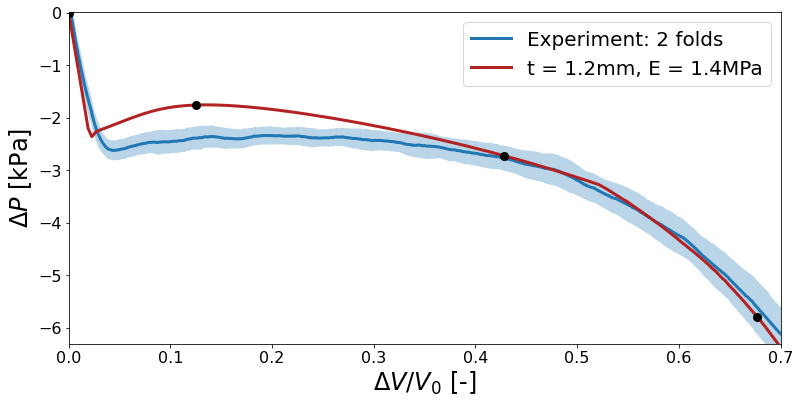

In [49]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

'''exp data'''
data_all = np.loadtxt('exp_results/PV_2f_Fig1_exp.csv', skiprows = 2, delimiter = ',')
vol_all = data_all[:,0]
pressure_2 = data_all[:,1:]
pressure_2_smooth = smooth_pv_data(pressure_2)
pressure_2_smooth_mean = np.mean(pressure_2_smooth, axis = 1)
pressure_2_smooth_std = np.std(pressure_2_smooth, axis = 1)

R = 8.8 #mm
H = 44.75 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

ax.plot(vol_all/vol_0, pressure_2_smooth_mean, label = 'Experiment: 2 folds', linewidth = linewidth_all)
ax.fill_between(vol_all/vol_0, pressure_2_smooth_mean + pressure_2_smooth_std, pressure_2_smooth_mean - pressure_2_smooth_std, alpha = 0.3)

'''sim data'''
frames_highlight = [0,32,57,105]
E, t = (1.4, 1.2)
data_cur = np.loadtxt(f'data_out/2fold-fitting-300_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3

ax.plot(vol_norm,pressure_kpa, label = f't = {t}mm, E = {E}MPa', color = 'firebrick', linewidth = linewidth_all)

for i, frame in enumerate(frames_highlight):
    ax.plot(vol_norm[frame],pressure_kpa[frame], 'o', color = 'k', markersize = markersize_all)


ax.legend(loc = 'best', fontsize = fontsize_legend);
ax.set_xlim(left = 0, right = 0.7)
ax.set_ylim(top = 0.01, bottom = -6.3)

ax.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax.set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
ax.tick_params(labelsize = fontsize_ticks)

# fig.savefig('data_processed/2folds_pv.jpg', dpi = 300)
vol_norm[frames_highlight]

array([-0.        ,  0.0671421 ,  0.40235752,  0.6935132 ])

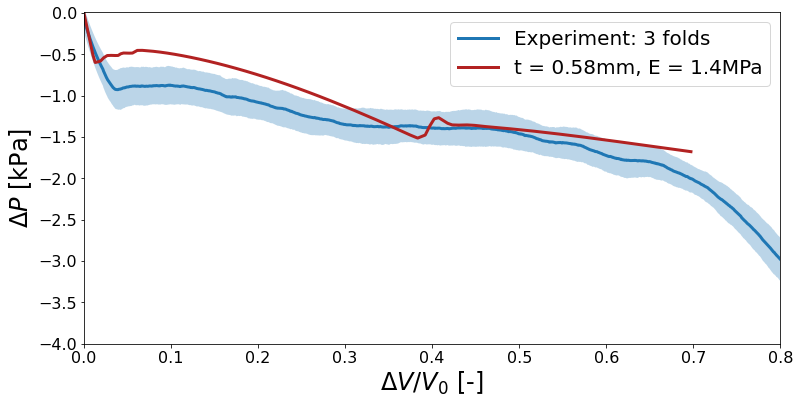

In [51]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

'''load exp data'''
data_all = np.loadtxt('exp_results/PV_3f_R10.csv', skiprows = 2, delimiter = ',', usecols=tuple(range(9)))
vol_all = data_all[:,0]

pressure_3_mean = np.mean(data_all[:,1:], axis = 1)
pressure_3_exp_std = np.std(data_all[:,1:], axis = 1)

pressure_3_smooth = smooth_pv_data(data_all[:,1:], 120)
pressure_3_smooth_mean = np.mean(pressure_3_smooth, axis = 1)
pressure_3_smooth_std = np.std(pressure_3_smooth, axis = 1)


#note: checked and this is averaged correctly w/o any extra volume stuff

R = 10 #mm
H = 27 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
pressure_0 = pressure_3_mean[0]

#plot exp
# ax.plot(vol_all/vol_0, pressure_4_mean, label = 'Experiment: 4 folds')
# ax.fill_between(vol_all/vol_0, pressure_4_mean + pressure_4_exp_std, pressure_4_mean - pressure_4_exp_std, alpha = 0.3)
eps = -0.009
ax.plot(vol_all/vol_0 + eps, pressure_3_smooth_mean, label = 'Experiment: 3 folds', linewidth = linewidth_all)
ax.fill_between(vol_all/vol_0 + eps, pressure_3_smooth_mean + pressure_3_smooth_std, pressure_3_smooth_mean - pressure_3_smooth_std, alpha = 0.3)

'''load sim data'''
t, E = (0.58, 1.4)
#plot nu = 0.5 up to \delta V/V_0 = 0.7 for fitted parameters
nu = 0.5
data_cur = np.loadtxt(f'data_out/3fold-fitting-411_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax.plot(vol_norm,pressure_kpa, label = rf't = {t}mm, E = {E}MPa', color = 'firebrick', linewidth = linewidth_all)



#set parameters for plot
ax.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax.set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
ax.set_xlim(left = 0, right = 0.8)
ax.set_ylim(top = 0.01, bottom = -4)
ax.tick_params(labelsize = fontsize_ticks)
ax.yaxis.offsetText.set_fontsize(fontsize_ticks)


ax.legend(loc = 'best', fontsize = fontsize_legend)

fig.savefig(f'{folder_out}/3folds_pv.jpg', dpi = 300)

frames_highlight = [0,28,63,138]
vol_norm[frames_highlight]